# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Feature Selection](#Feature-Selection)
- [Variance Inflation Factor based Selection](#Variance-Inflation-Factor-based-Selection)
- [Pipeline Building](#Pipeline-Building)
- [Naive Modeling](#Naive-Modeling)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction

#### Building Basic Linear Models
- We begin with a basic model to establish a benchmark for future, more complex models
    
#### Day 2: Naive Modeling

## Importing Libraries

In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [2]:
train_data = pl.read_csv("train_data.csv")
test_data = pl.read_csv("test_data.csv")
train_data.shape,test_data.shape

((5611, 19), (1406, 19))

In [3]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

## Feature selection

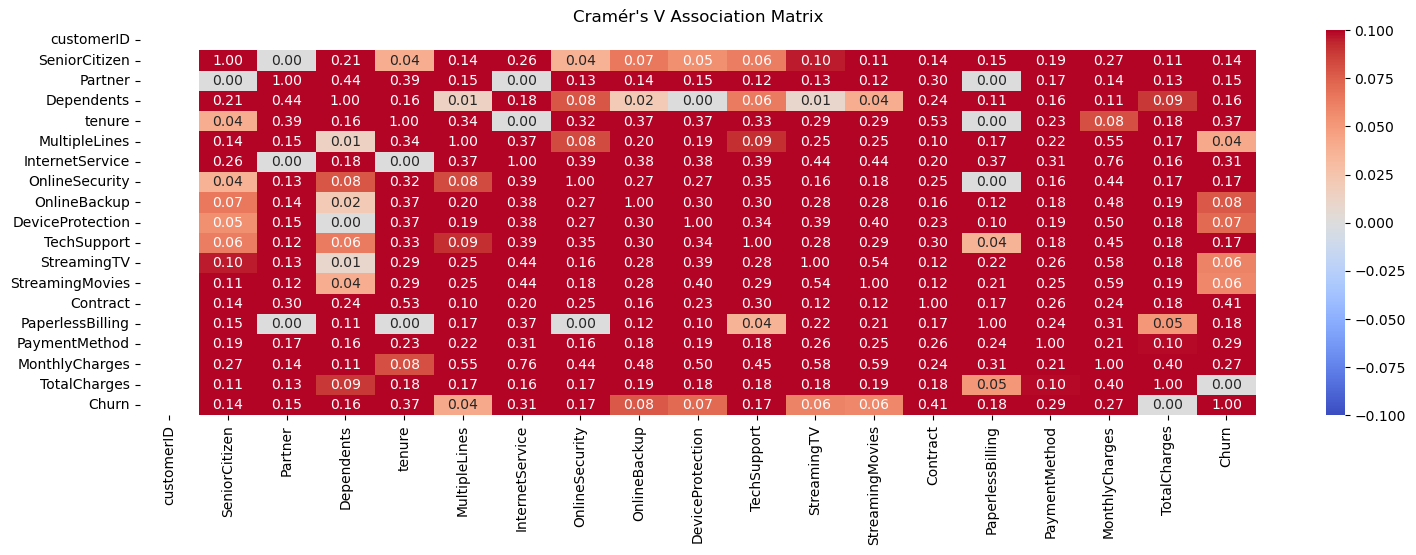

In [11]:
plot_Association_heatmap(train_data,train_data.columns)

Dropping Based on Low Associations

In [13]:
train_data=train_data.drop("MultipleLines","OnlineBackup","DeviceProtection",'StreamingTV','StreamingMovies','TotalCharges')
test_data=test_data.drop("MultipleLines","OnlineBackup","DeviceProtection",'StreamingTV','StreamingMovies','TotalCharges')

## Variance inflation factor based selection

In [14]:
calculate_vif(train_data,"Churn")

,variables,VIF
0,const,66.933055
5,InternetService,7.989507
8,MonthlyCharges,7.804072
4,tenure,2.381965
6,Contract,2.339845


No high multicollinear features

imbalance ratio

In [6]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2648369274639102

## Pipeline Building

- Assigning class weigths to overcome imbalance problems

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['OnlineSecurity',
                                                   'TechSupport',
                                                   'PaymentMethod']),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'tenure',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'MonthlyCharges'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.648369274639102}))])

## Naive Modeling

In [16]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

Mean Train roc auc Score: 0.8401249989598222
Mean Train recall Score: 0.7785552622664355

Mean Test roc auc Score: 0.8381360569010738
Mean Test recall Score: 0.7766578995102484


Recall score: 0.81
Correlation : 0.49961640979033434
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82      1031
           1       0.54      0.81      0.64       375

    accuracy                           0.76      1406
   macro avg       0.73      0.78      0.73      1406
weighted avg       0.81      0.76      0.77      1406



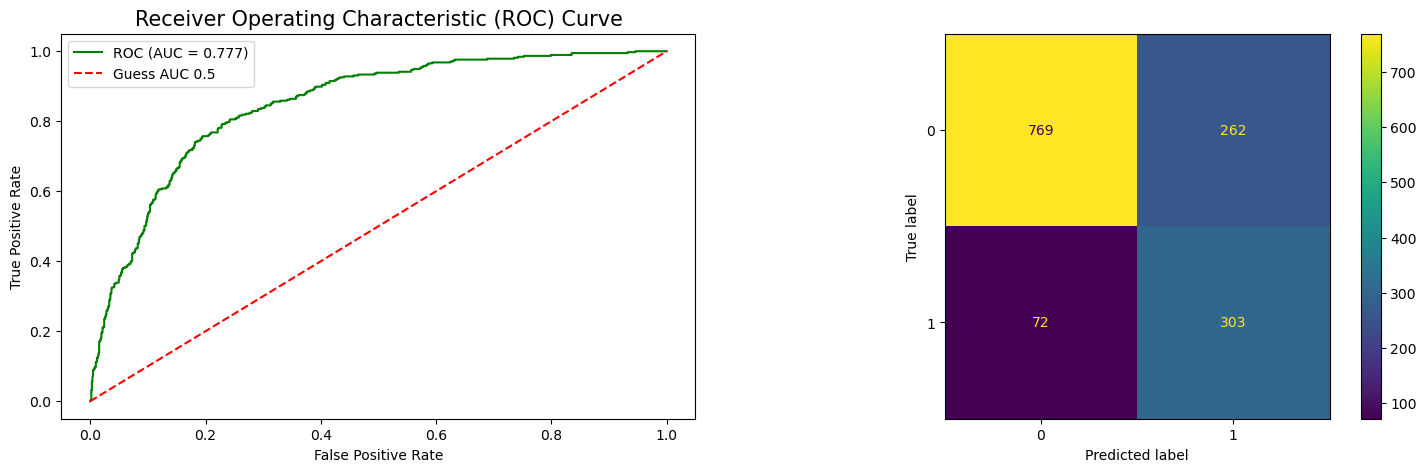

In [17]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

## Results
### Model Performance Summary (Day 2 - Naive Modeling for Churn Prediction)

#### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.8401
* **Mean Train Recall Score**: 0.7786

* **Mean Test ROC AUC Score**: 0.8381
* **Mean Test Recall Score**: 0.7767

#### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.81

### Correlation

* **Correlation**: 0.4996

#### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.91      | 0.75   | 0.82     | 1031    |
| **Class 1**   | 0.54      | 0.81   | 0.64     | 375     |
| **Accuracy**  |           | 0.76   |          | 1406    |
| **Macro Avg** | 0.73      | 0.78   | 0.73     | 1406    |
| **Weighted Avg** | 0.81   | 0.76   | 0.77     | 1406    |

#### Insights

* **Improved Recall Performance**: Compared to Day 1's preprocessing results, the recall scores have significantly improved. The mean train recall score increased from 0.5505 to 0.7786, and the mean test recall score improved from 0.5462 to 0.7767. The holdout set recall score also increased from 0.56 to 0.81, indicating the model is now more effective at identifying churn cases.

* **Consistency**: The ROC AUC scores for both train and test sets are slightly lower than Day 1 (train: 0.8470 to 0.8401, test: 0.8439 to 0.8381). However, the recall improvement suggests the model prioritizes identifying positive cases (churn) over overall discrimination ability, which is beneficial for churn prediction.

* **Precision vs. Recall Trade-off**: The precision for class 1 (churn) decreased from 0.66 to 0.54, while the recall increased significantly (0.56 to 0.81). This trade-off is expected, as increasing recall often results in more false positives, lowering precision. The higher recall is valuable in churn prediction to ensure more potential churn cases are captured.

* **Overall Accuracy**: The overall accuracy slightly decreased from 0.81 to 0.76, reflecting the model's focus on improving recall for the minority class (churn).

* **Correlation**: The correlation increased from 0.4790 to 0.4996, indicating a stronger relationship between predicted probabilities and actual class labels.

* **Class Imbalance**: Despite the improvements in recall, the support values (class 0: 1031, class 1: 375) still reveal a class imbalance. The model's performance metrics should continue to account for this imbalance.

#### Improvements from Day 1

* **Significant Recall Improvement**: The major improvement is in recall, both on cross-validation and the holdout set. This enhancement is crucial for churn prediction, where identifying as many churners as possible is often more important than minimizing false positives.

* **Model Robustness**: The consistent ROC AUC scores and improved recall across training, test, and holdout sets indicate that the naive modeling approach has provided a more robust model for identifying churn.

* **Better Handling of Positive Class**: The new model handles the positive class (churn) more effectively, improving its practical utility for predicting customer churn.

#### Recommendations for Further Improvement

* **Precision Enhancement**: To balance the precision-recall trade-off, consider further tuning the model or using ensemble methods to improve precision without sacrificing recall too much.
* **Feature Engineering**: Additional feature engineering could help in capturing more relevant patterns, potentially improving both recall and precision.
* **Handling Class Imbalance**: Techniques like balanced class weights or advanced resampling methods can be explored further to address the remaining class imbalance.

By focusing on these aspects, the model can continue to improve, providing even more reliable predictions for churn.

## Conclusion
- 81% of churners are identified with 54% precision (chance that our predicted churners are actually churners). Indicating nearly half our predicted churners are actual Churners